In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import h5py

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt

from plotting import *
from data_processing import *
from pinn import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sociohydrodynamics PINNS


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \phi_i \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

## Load data

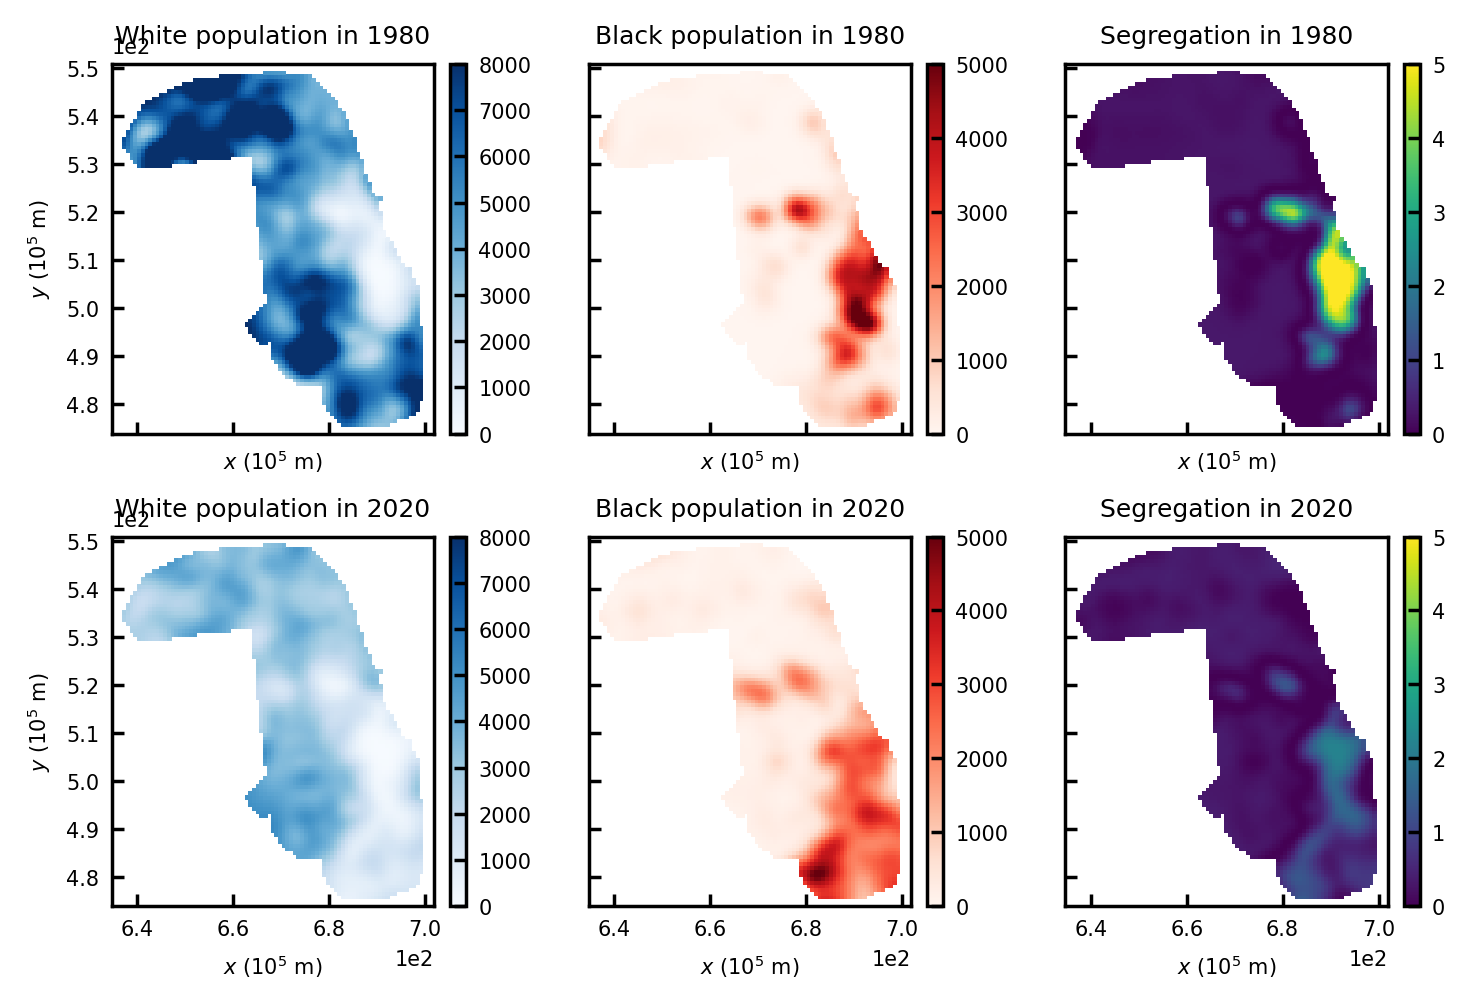

In [2]:
'''
Load and plot data from HDF5 files 
'''
with h5py.File("data/cook_IL.hdf5", "r") as d:
    x_grid = d["x_grid"][:] / 1e3
    y_grid = d["y_grid"][:] / 1e3
    w_grid = d["w_grid_array_masked"][:].transpose(2, 0, 1)
    b_grid = d["b_grid_array_masked"][:].transpose(2, 0, 1)
    
    for ii in range(w_grid.shape[0]):
        w_grid[ii] = smooth_with_fill(w_grid[ii], sigma=2)
        b_grid[ii] = smooth_with_fill(b_grid[ii], sigma=2)
        
    max_grid = (w_grid + b_grid).max(axis=0) * 1.1
    w_grid /= max_grid
    b_grid /= max_grid
                
T = np.array([1980, 1990, 2000, 2010, 2020])

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

kwargs = dict(x_grid=x_grid, y_grid=y_grid, wmax=8000, bmax=5000, smax=5, max_grid=max_grid)

ii = 0
plot_white_black_seg(fig, ax[0], w_grid[ii], b_grid[ii], T[ii], **kwargs)

ii = 4
plot_white_black_seg(fig, ax[1], w_grid[ii], b_grid[ii], T[ii], **kwargs)

plt.tight_layout()

(100, 87) (100, 87) (5, 100, 87) (5, 100, 87) (5, 100, 87)
(19005,) (19005,) (19005,) (19005,) (19005,)
(1000,) (1000,) (1000,) (1000,) (1000,)


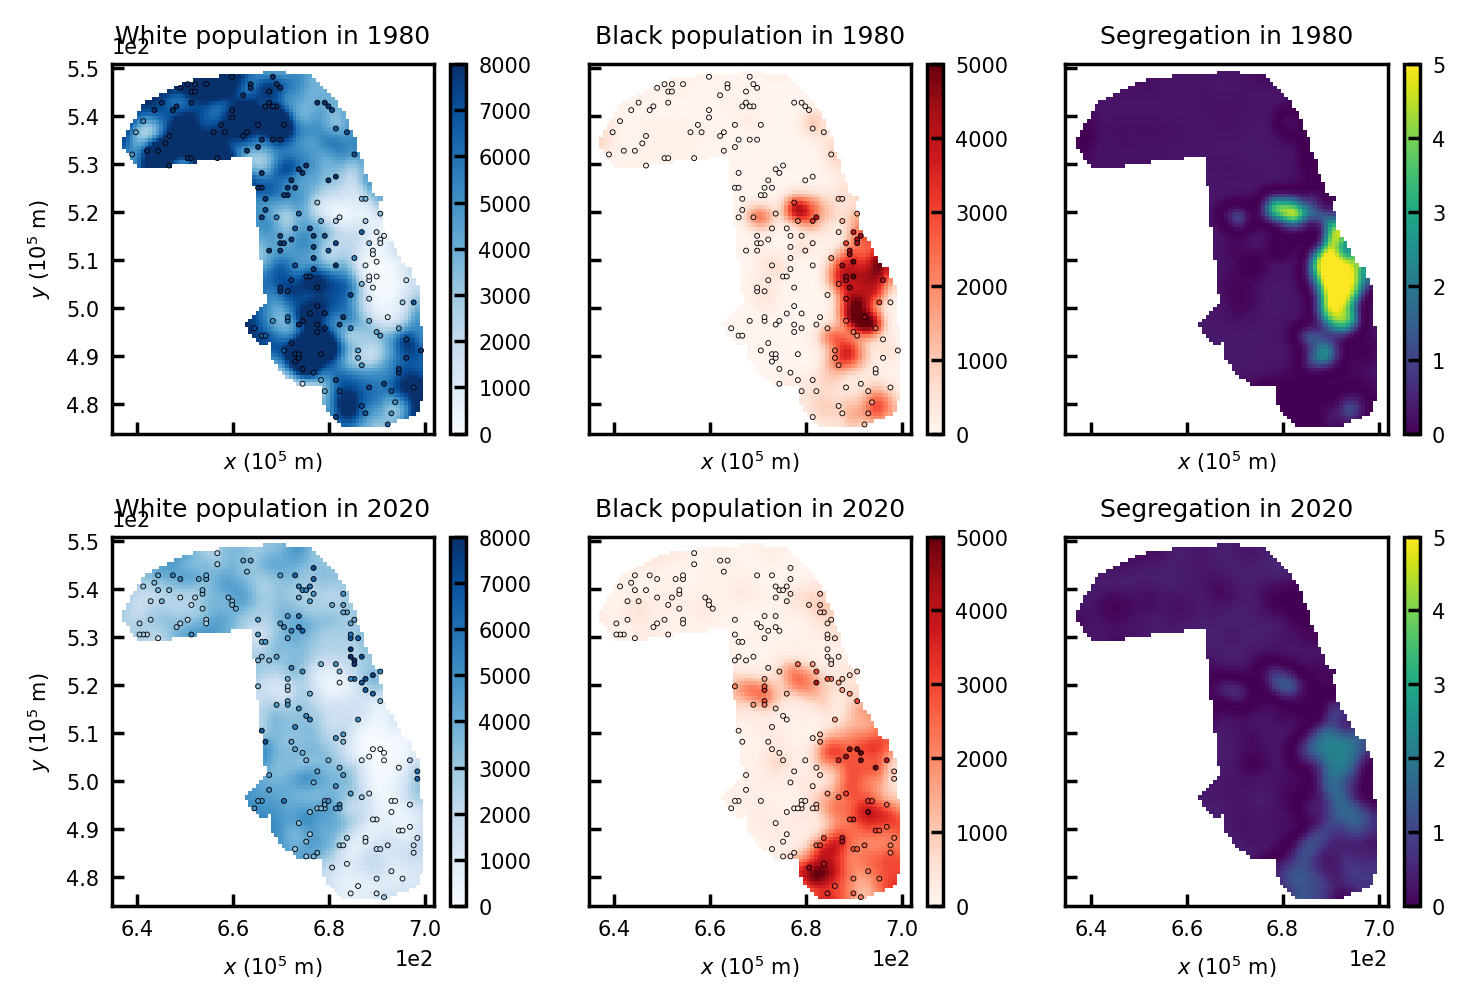

In [3]:
#Convert points from YX grid to TYX list
x = np.tile(x_grid[None], (len(T), 1, 1))
y = np.tile(y_grid[None], (len(T), 1, 1))
t = np.tile(T[:, None, None], (1, *x_grid.shape))

print(x_grid.shape, y_grid.shape, t.shape, w_grid.shape, b_grid.shape)

#Remove any points where there are NaNs
keep = np.logical_and(~np.isnan(w_grid), ~np.isnan(b_grid))
w = w_grid[keep]
b = b_grid[keep]
t = t[keep]
y = y[keep]
x = x[keep]

print(x.shape, y.shape, t.shape, w.shape, b.shape)

#Select points for reconstruction loss
idx = np.random.choice(np.prod(x.shape), 1000, replace=False)

x_u = x[idx]
y_u = y[idx]
t_u = t[idx]
w_u = w[idx]
b_u = b[idx]

print(x_u.shape, y_u.shape, t_u.shape, w_u.shape, b_u.shape)

margs = [
    torch.from_numpy(x_u).float(),
    torch.from_numpy(y_u).float(),
    torch.from_numpy(t_u).float(),
    torch.from_numpy(w_u).float(),
    torch.from_numpy(b_u).float(),
]

#plot points
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

kwargs = dict(x_grid=x_grid, y_grid=y_grid, wmax=8000, bmax=5000, smax=5, max_grid=max_grid)
swargs = dict(s=2, vmin=0, alpha=1, edgecolor='black', linewidths=0.25)

ii = 0
plot_white_black_seg(fig, ax[0], w_grid[ii], b_grid[ii], T[ii], **kwargs)

msk = t_u == T[ii]
ax[0, 0].scatter(x_u[msk], y_u[msk], c=w_u[msk], **swargs, cmap='Blues')
ax[0, 1].scatter(x_u[msk], y_u[msk], c=b_u[msk], **swargs, cmap='Reds')

ii = 4
plot_white_black_seg(fig, ax[1], w_grid[ii], b_grid[ii], T[ii], **kwargs)

msk = t_u == T[ii]
ax[1, 0].scatter(x_u[msk], y_u[msk], c=w_u[msk], **swargs, cmap='Blues')
ax[1, 1].scatter(x_u[msk], y_u[msk], c=b_u[msk], **swargs, cmap='Reds')

plt.tight_layout()

In [4]:
def plot(model):
    tyx = np.stack([t, y, x], axis=-1)
    tyx = torch.from_numpy(tyx).float().to(device)
    with torch.no_grad():
        wb = model(tyx).cpu().numpy()
        print(wb.shape)

    print(wb.mean(axis=0), wb.std(axis=0))

    w_pred = np.zeros_like(w_grid)
    b_pred = np.zeros_like(b_grid)
    D_pred = np.zeros([*w_grid.shape, 4])

    w_pred[keep] = wb[:, 0]
    w_pred[~keep] = np.nan

    b_pred[keep] = wb[:, 1]
    b_pred[~keep] = np.nan
    
    #plot points
    fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

    kwargs = dict(x_grid=x_grid, y_grid=y_grid, wmax=8000, bmax=5000, smax=5, max_grid=max_grid)

    ii = 0
    plot_white_black_seg(fig, ax[0], w_pred[ii], b_pred[ii], T[ii], **kwargs)

    ii = 4
    plot_white_black_seg(fig, ax[1], w_pred[ii], b_pred[ii], T[ii], **kwargs)

    plt.tight_layout()

## Diffusion NN PINN

[3, 256, 256, 256, 256, 256, 6]
(19005, 6)
[  0.5347626    0.142821   -18.883448     0.08726975   0.02838085
 -10.435781  ] [ 0.25236246  0.19761954 10.497714    1.0871369   0.16794841  5.8709106 ]
DiffusionNN_LinearPINN Iter = 55000	Loss = 5.374e-02, MSE = 5.047e-02, Phys = 3.276e-03
  dt P_w = div( D_wi grad(P_i)) - -0.0214 grad^4 P_w
  dt P_b = div( D_bi grad(P_i)) - -0.05 grad^4 P_b



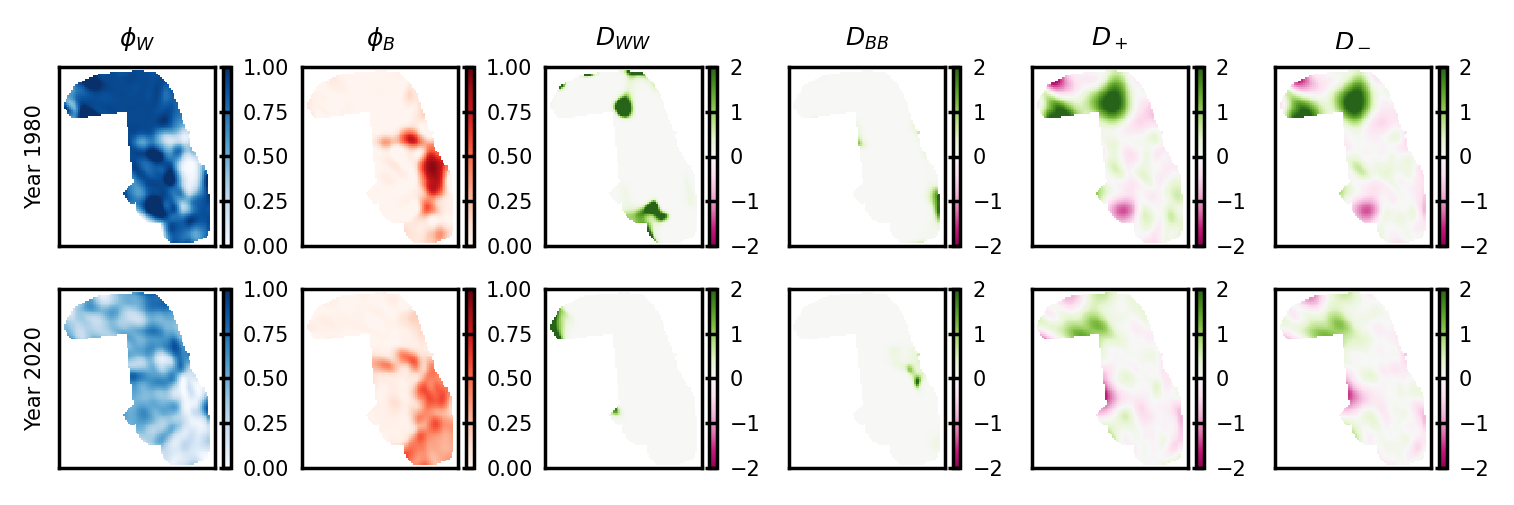

In [6]:
from pinn import *
from plotting import plot_white_black_Dij

def plot(model):
    tyx = np.stack([t, y, x], axis=-1)
    tyx = torch.from_numpy(tyx).float().to(device)
    with torch.no_grad():
        wb = model(tyx).cpu().numpy()
        print(wb.shape)

    print(wb.mean(axis=0), wb.std(axis=0))

    w_pred = np.zeros_like(w_grid)
    b_pred = np.zeros_like(b_grid)
    D_pred = np.zeros([*w_grid.shape, 4])

    w_pred[keep] = wb[:, 0]
    w_pred[~keep] = np.nan

    b_pred[keep] = wb[:, 1]
    b_pred[~keep] = np.nan

    D_pred[keep] = wb[:, 2:]
    D_pred[~keep] = np.nan
    
    #plot points
    fig, ax = plt.subplots(2, 6, figsize=(6, 2), sharey=True, sharex=True)

    ii = 0
    plot_white_black_Dij(fig, ax[0], w_pred[ii], b_pred[ii], D_pred[ii], T[ii], x_grid, y_grid, title=True)
    ax[0,0].set_ylabel(f'Year {T[ii]}')

    ii = 4
    plot_white_black_Dij(fig, ax[1], w_pred[ii], b_pred[ii], D_pred[ii], T[ii], x_grid, y_grid)
    ax[1,0].set_ylabel(f'Year {T[ii]}')

    plt.tight_layout()

modeltype = DiffusionNN_PINN
modeltype = DiffusionNN_LinearPINN
info = torch.load(f'data/{modeltype.__name__}', map_location='cpu')
model = modeltype(*margs).to(device)#, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
model.iter = info['iteration']
plot(model)
model.print()

## Sociohydrodynamics PINN


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \phi_i \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

[3, 256, 256, 256, 256, 256, 2]
(19005, 2)
[0.5301874  0.14131239] [0.24581455 0.19585499]
Iter = 45000	Loss = 3.034e-02, MSE = 3.017e-02, Phys = 1.687e-04
  dt P_w = div( D_wi grad(P_i) - 0.149 (1 - P) P_w grad^3 P_w )
	D_ww =  0.185  + -0.455 P_w + -0.817 P_b + 0.29 P_w^2 + 0.783 P_b^2 + 0.693 P_w P_b
	D_wb =  0.0304  + -0.224 P_w + -0.368 P_b + 0.348 P_w^2 + 0.453 P_b^2 + 0.242 P_w P_b
  dt P_b = div( D_bi grad(P_i) - -0.198 (1 - P) P_b grad^3 P_b )
	D_bw =  0.0232  + -0.104 P_w + 0.0367 P_b + 0.0842 P_w^2 + -0.154 P_b^2 + 0.118 P_w P_b
	D_bb =  0.00499  + 0.00476 P_w + 0.378 P_b + -0.0722 P_w^2 + -0.46 P_b^2 + -0.298 P_w P_b



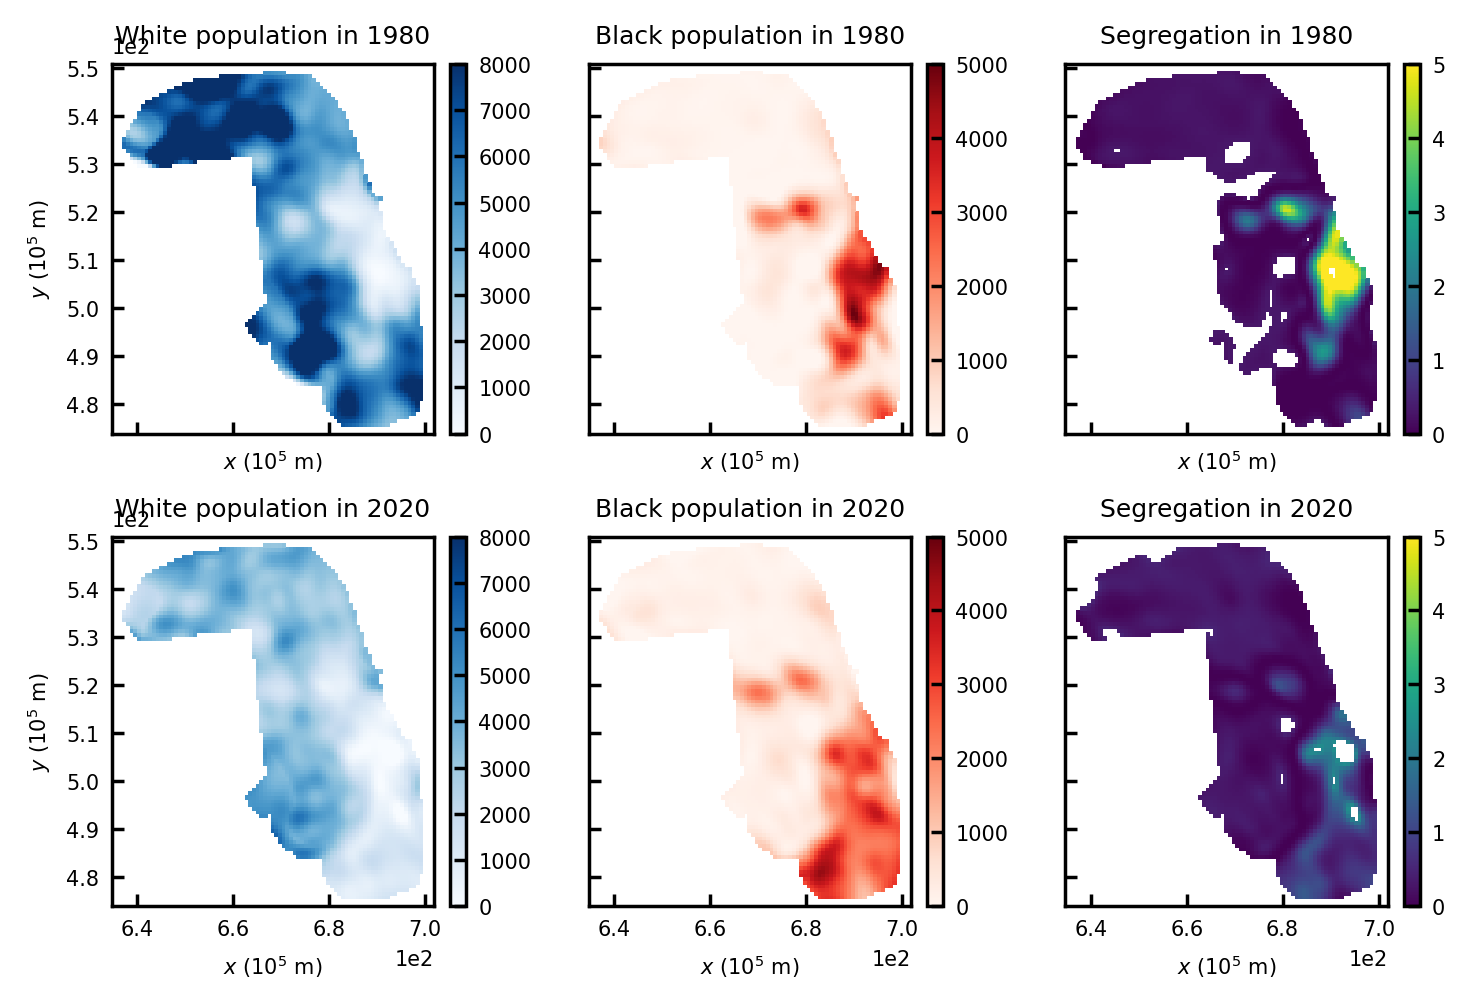

In [6]:
from pinn import *

modeltype = SociohydrodynamicsPINN
info = torch.load(f'data/{modeltype.__name__}', map_location='cpu')
model = modeltype(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
model.iter = info['iteration']
plot(model)
model.print()

## Diffusion PINN with Linear Gamma terms
$$  \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j - \Gamma_i \nabla^3 \phi_i \bigg)$$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

[3, 256, 256, 256, 256, 256, 2]
(19005, 2)
[0.52773356 0.14548828] [0.24189799 0.19471048]
Iter = 50000	Loss = 2.557e-02, MSE = 2.548e-02, Phys = 9.264e-05
  dt P_w = div( D_wi grad(P_i)) - 0.0254 grad^4 P_w
	D_ww =  -0.0324 
	D_wb =  -0.00903 
  dt P_b = div( D_bi grad(P_i)) - -0.0635 grad^4 P_b
	D_bw =  0.00175 
	D_bb =  0.0701 



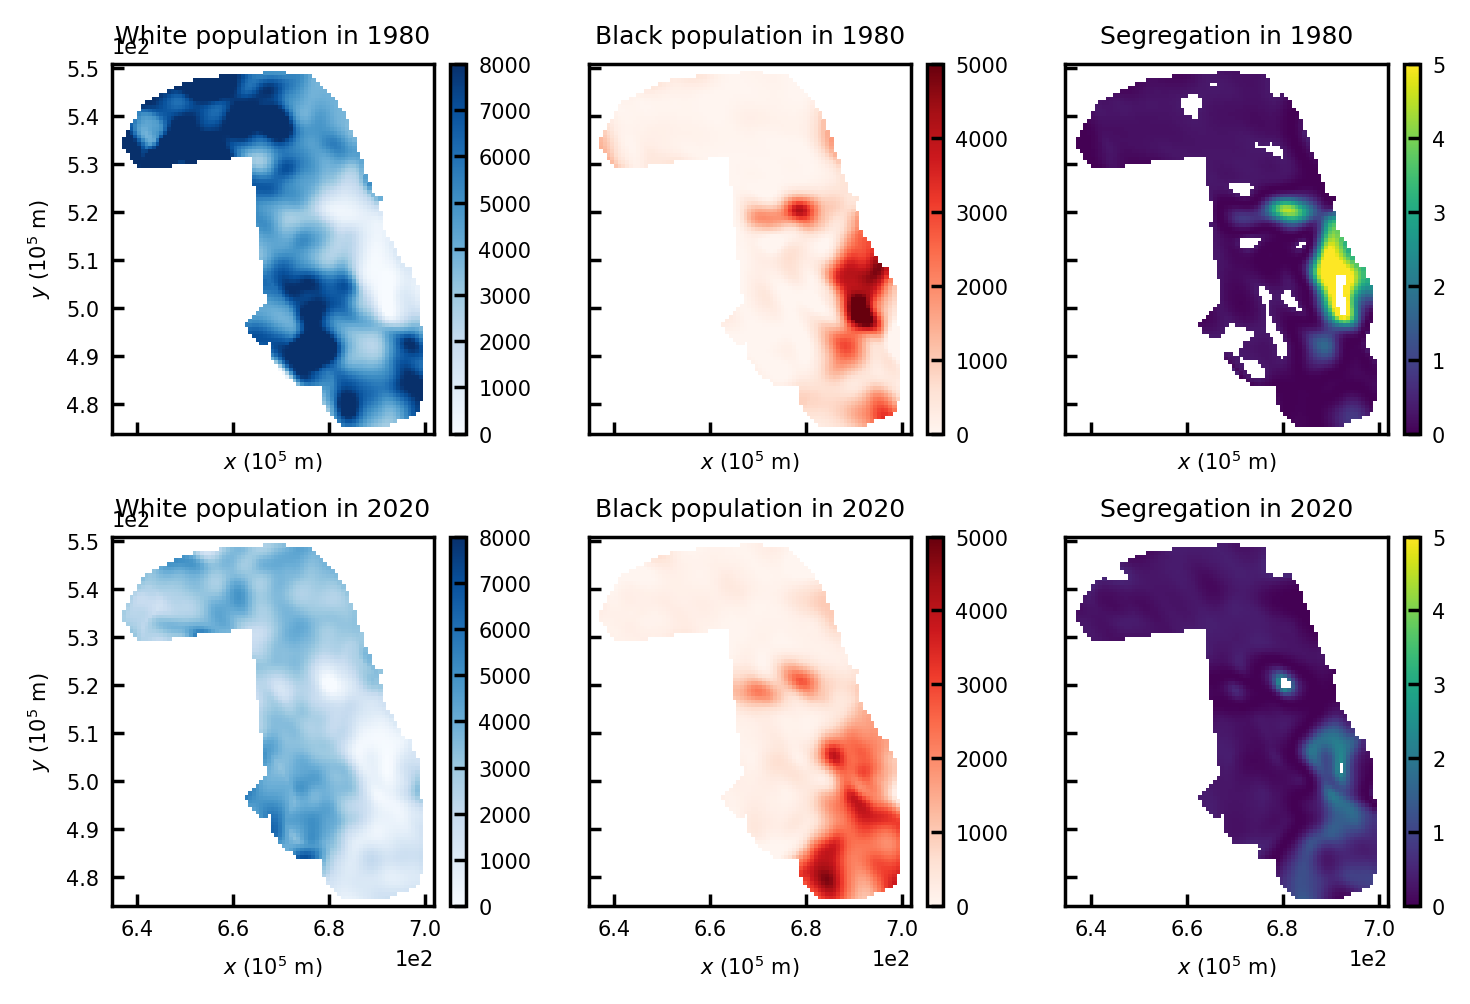

In [7]:
from pinn import *

modeltype = LinearDiffusionLinearPINN
info = torch.load(f'data/{modeltype.__name__}', map_location='cpu')
model = modeltype(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
model.iter = info['iteration']
plot(model)
model.print()

[3, 256, 256, 256, 256, 256, 2]
(19005, 2)
[0.52955663 0.14418525] [0.23558705 0.19693832]
Iter = 65000	Loss = 7.220e-02, MSE = 7.191e-02, Phys = 2.890e-04
  dt P_w = div( D_wi grad(P_i)) - -3.7e-10 grad^4 P_w
	D_ww =  -5.94e-05  + 0.000103 P_w + 4.7e-05 P_b
	D_wb =  -4.86e-05  + 6.16e-05 P_w + 5.74e-05 P_b
  dt P_b = div( D_bi grad(P_i)) - 2.4e-09 grad^4 P_b
	D_bw =  -3.01e-07  + 7.93e-06 P_w + -4.67e-05 P_b
	D_bb =  -1.55e-05  + 2.23e-05 P_w + 1.52e-06 P_b



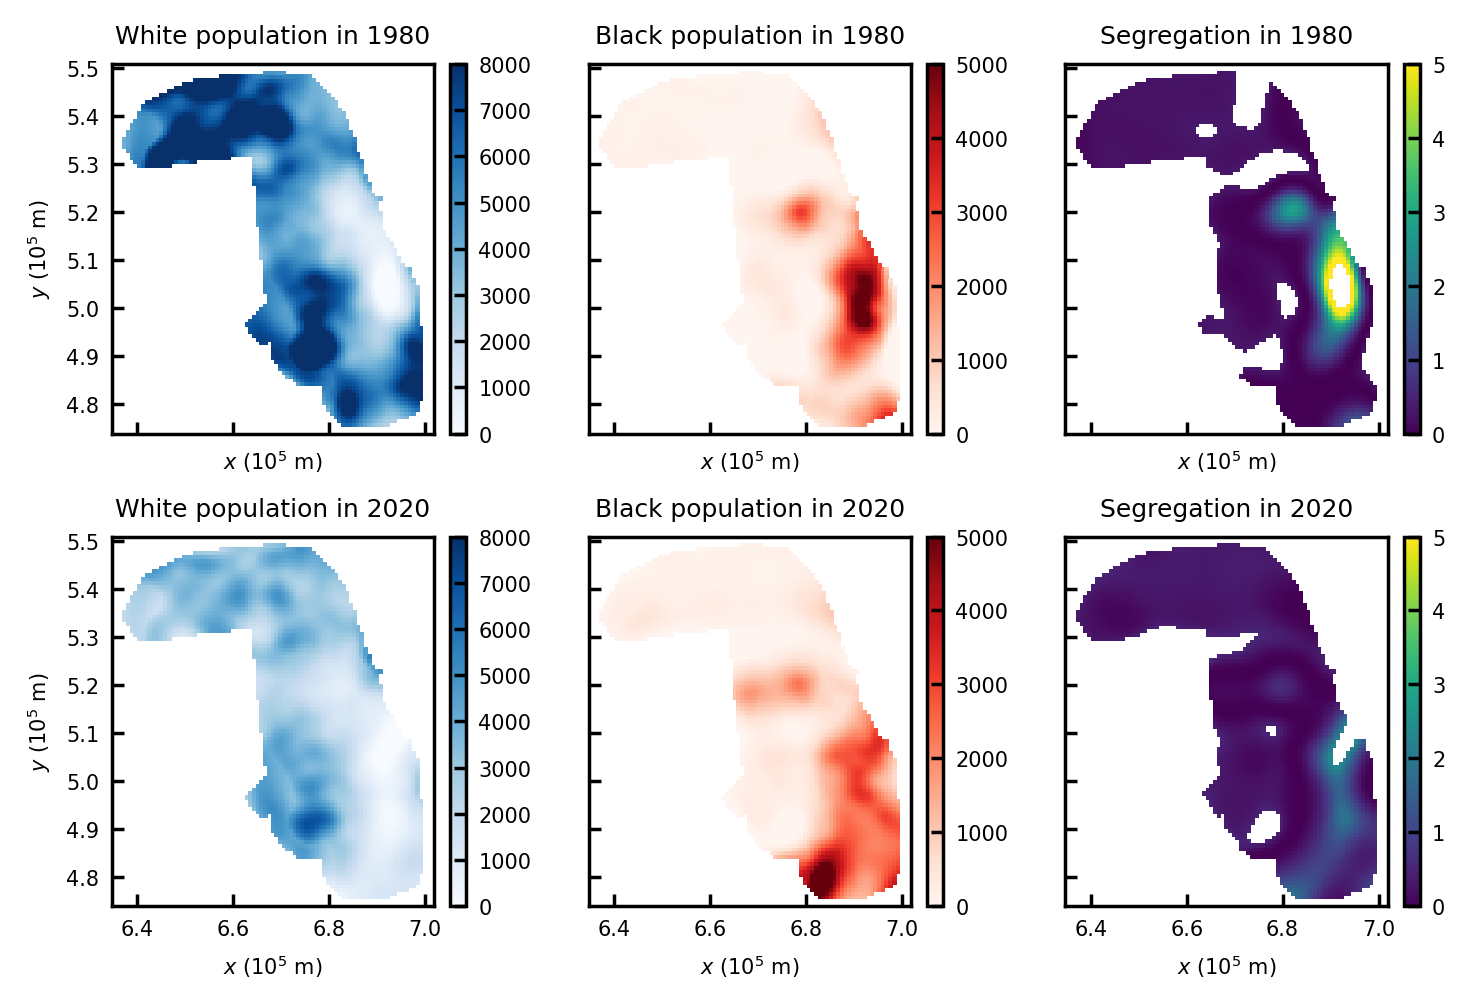

In [15]:
modeltype = QuadraticDiffusionLinearPINN
info = torch.load(f'data/{modeltype.__name__}', map_location='cpu')
model = modeltype(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
model.iter = info['iteration']
plot(model)
model.print()

[3, 256, 256, 256, 256, 256, 2]
(19005, 2)
[0.52817243 0.1479916 ] [0.23268233 0.1939617 ]
Iter = 65000	Loss = 5.802e-02, MSE = 5.779e-02, Phys = 2.318e-04
  dt P_w = div( D_wi grad(P_i)) - 4.4e-10 grad^4 P_w
	D_ww =  0.000283  + -0.000862 P_w + -0.00124 P_b + 0.000627 P_w^2 + 0.00128 P_b^2 + 0.00164 P_w P_b
	D_wb =  0.000425  + -0.00116 P_w + -0.00148 P_b + 0.000775 P_w^2 + 0.00132 P_b^2 + 0.00181 P_w P_b
  dt P_b = div( D_bi grad(P_i)) - -1.62e-10 grad^4 P_b
	D_bw =  5.48e-06  + 3.87e-06 P_w + 1.51e-05 P_b + 6.31e-06 P_w^2 + -4.49e-05 P_b^2 + -0.000194 P_w P_b
	D_bb =  2.32e-05  + -6.88e-05 P_w + -1.19e-05 P_b + 6.38e-05 P_w^2 + -1.17e-05 P_b^2 + -0.000106 P_w P_b



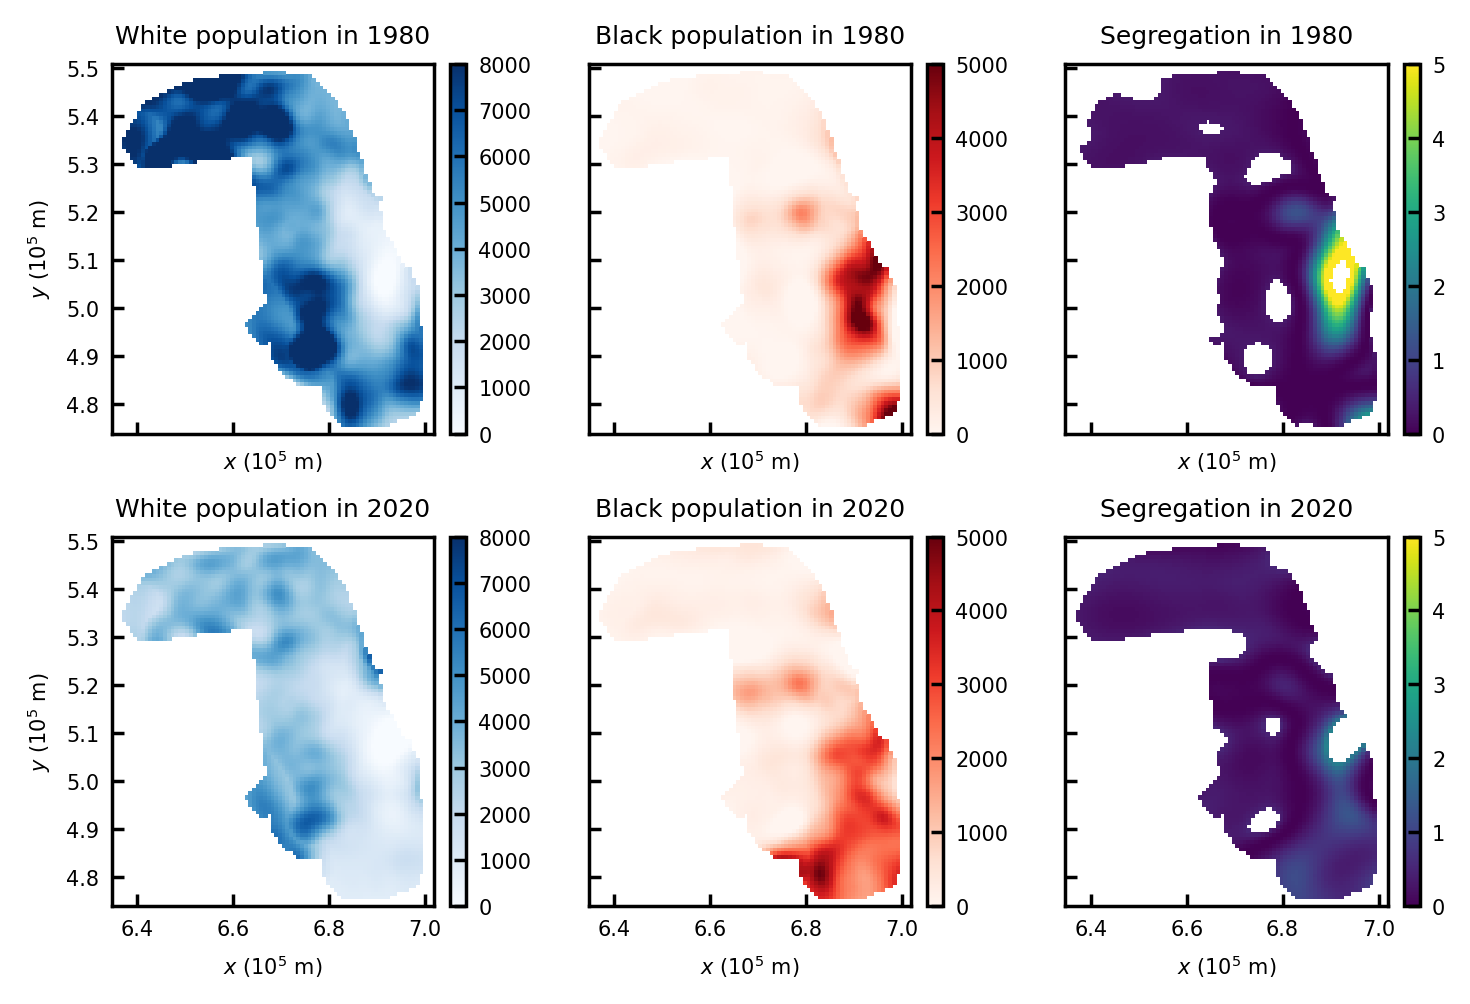

In [16]:
modeltype = CubicDiffusionLinearPINN
info = torch.load(f'data/{modeltype.__name__}', map_location='cpu')
model = modeltype(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
model.iter = info['iteration']
plot(model)
model.print()

## Uninformed Neural Network (Interpolator)

[3, 256, 256, 256, 256, 256, 2]
(19005, 2)
[0.5293125  0.14548138] [0.24185929 0.19572188]
Iter = 500000	Loss = 4.239e-04, MSE = 4.239e-04, Phys = 0.000e+00


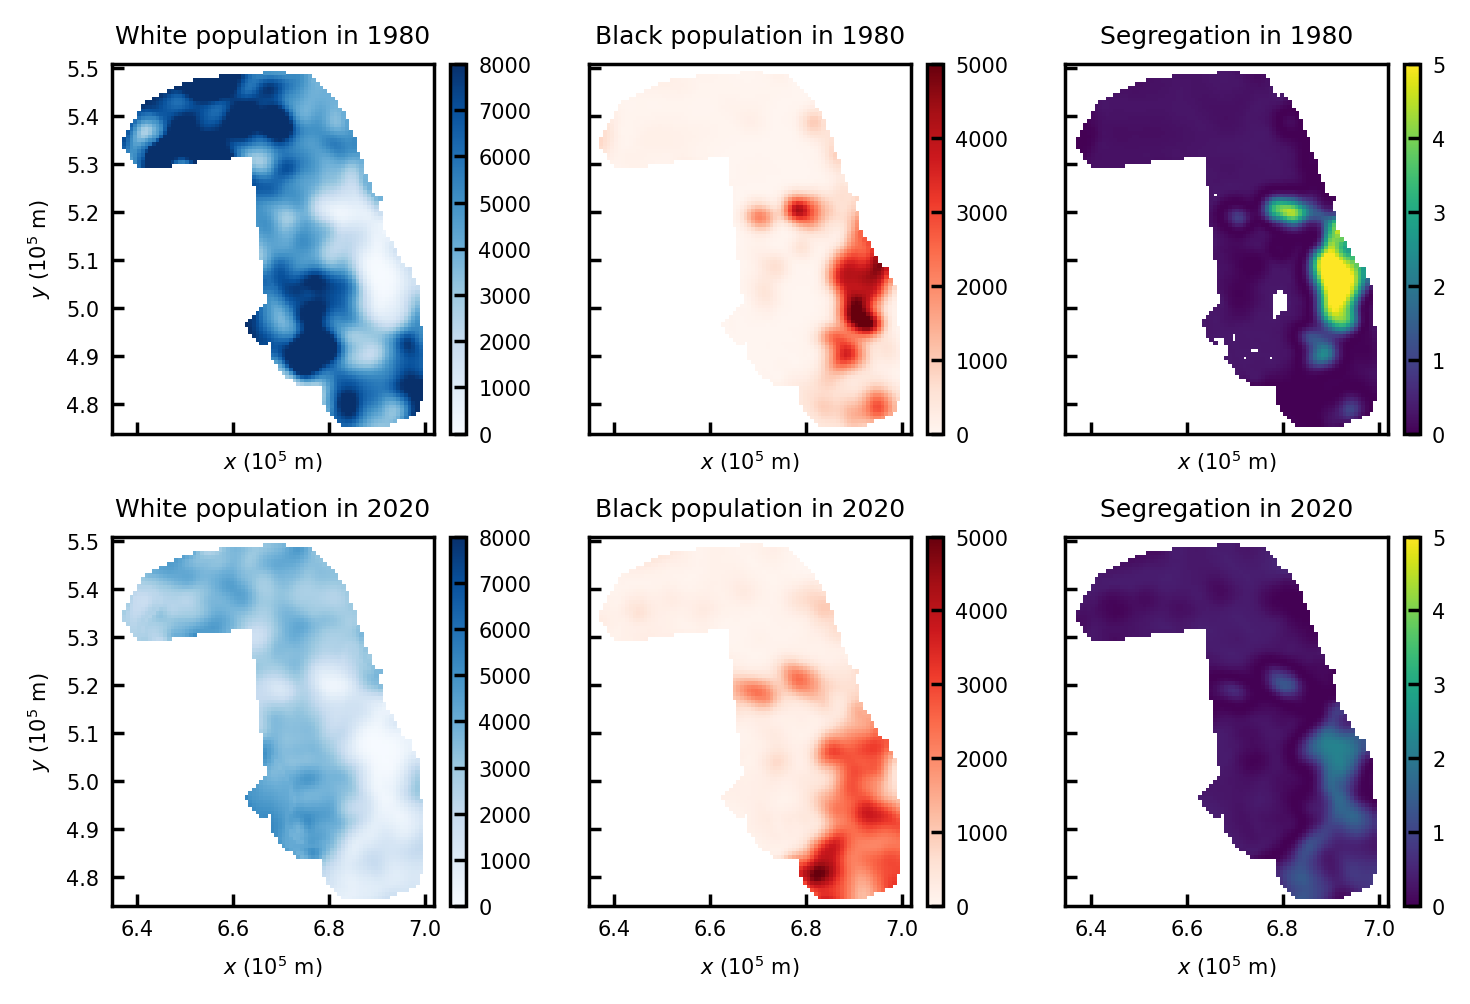

In [7]:
modeltype = UninformedPINN
info = torch.load(f'data/{modeltype.__name__}', map_location='cpu')
model = modeltype(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
model.iter = info['iteration']
plot(model)
model.print()

## Linear Diffusion PINN 
$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j \bigg) $$
$$ D_{ij} = c^0_{ij} $$

[3, 256, 256, 256, 256, 256, 2]
(36635, 2)
[0.53670794 0.13010593] [0.21338104 0.14695048]
LinearDiffusionPINN Iter = 70000	Loss = 4.083e-03, MSE = 4.008e-03, Phys = 7.542e-05
  dt P_w = div( D_wi grad(P_i))
	D_ww =  0.00304 
	D_wb =  -0.00757 
  dt P_b = div( D_bi grad(P_i))
	D_bw =  -0.00742 
	D_bb =  0.0231 



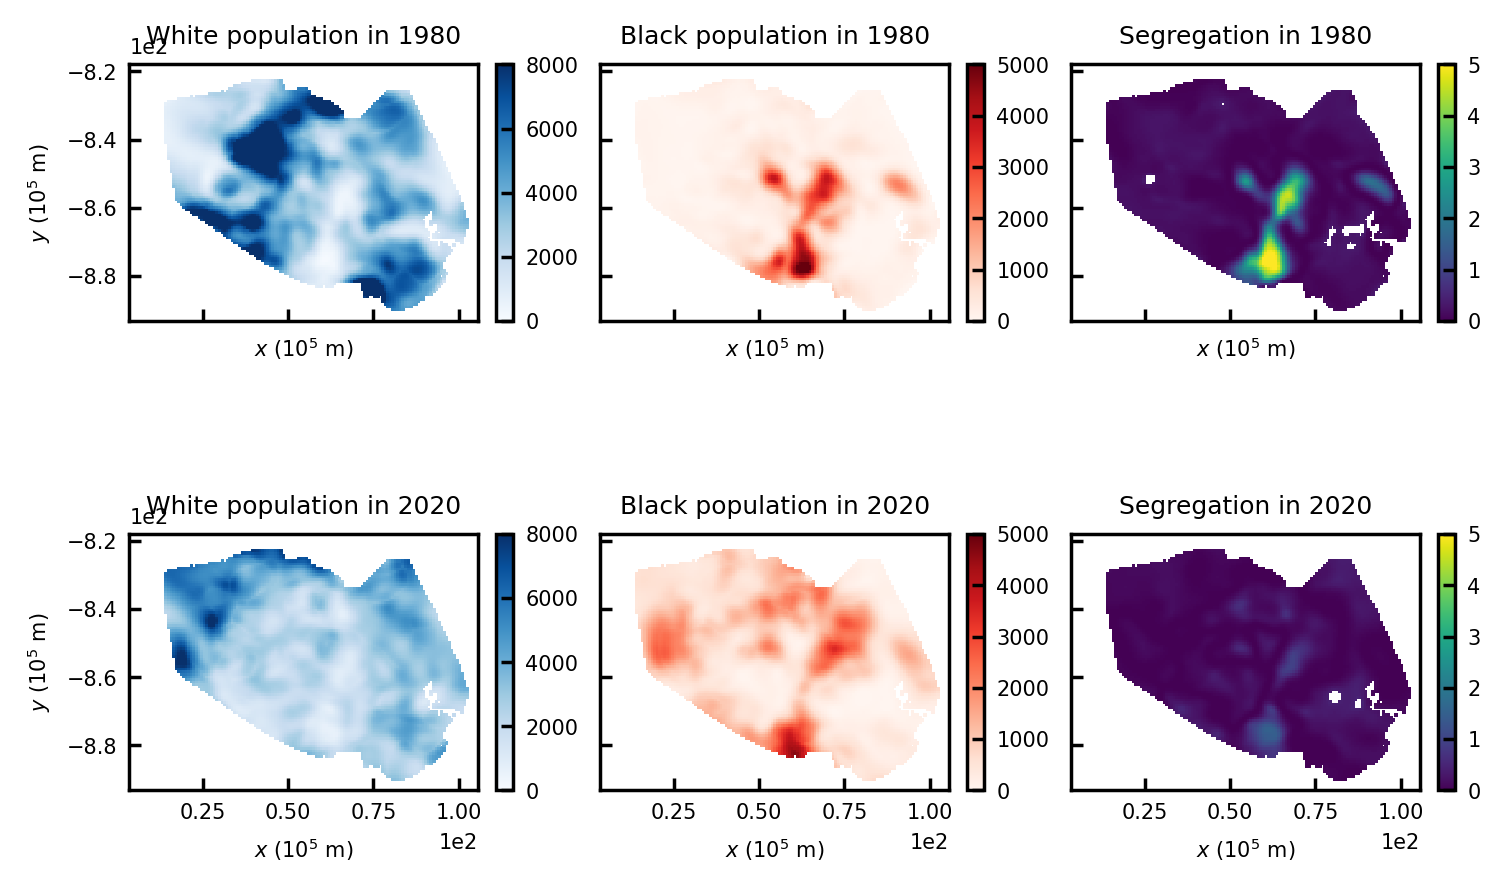

In [8]:
from pinn import *
modeltype = LinearDiffusionPINN
info = torch.load(f'data/{modeltype.__name__}', map_location='cpu')
model = modeltype(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
model.iter = info['iteration']
plot(model)
model.print()

## Quadratic Diffusion PINN

$$ \dot{\phi}_i = \nabla \cdot \big( D_{ij} \nabla \phi_j \big) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B$$

$$ \dot{\phi}_i = D_{ij} \nabla^2 \phi_j + \nabla D_{ij} \cdot \nabla \phi_j $$

$$ \nabla D_{ij} =  c^1_{ij} \nabla \phi_A + c^2_{ij} \nabla \phi_B$$

[3, 256, 256, 256, 256, 256, 2]
(19005, 2)
[0.52927953 0.1454342 ] [0.24186814 0.19572213]
Iter = 500000	Loss = 4.015e-04, MSE = 3.795e-04, Phys = 2.207e-05
  dt P_w = div( D_wi grad(P_i))
	D_ww =  1.41e-06  + -3.09e-06 P_w + 2.05e-06 P_b
	D_wb =  1.37e-06  + -8.23e-06 P_w + 3.09e-06 P_b
  dt P_b = div( D_bi grad(P_i))
	D_bw =  -1.21e-06  + 3.98e-06 P_w + -1.15e-05 P_b
	D_bb =  -5.91e-06  + 2.43e-05 P_w + 1.04e-05 P_b



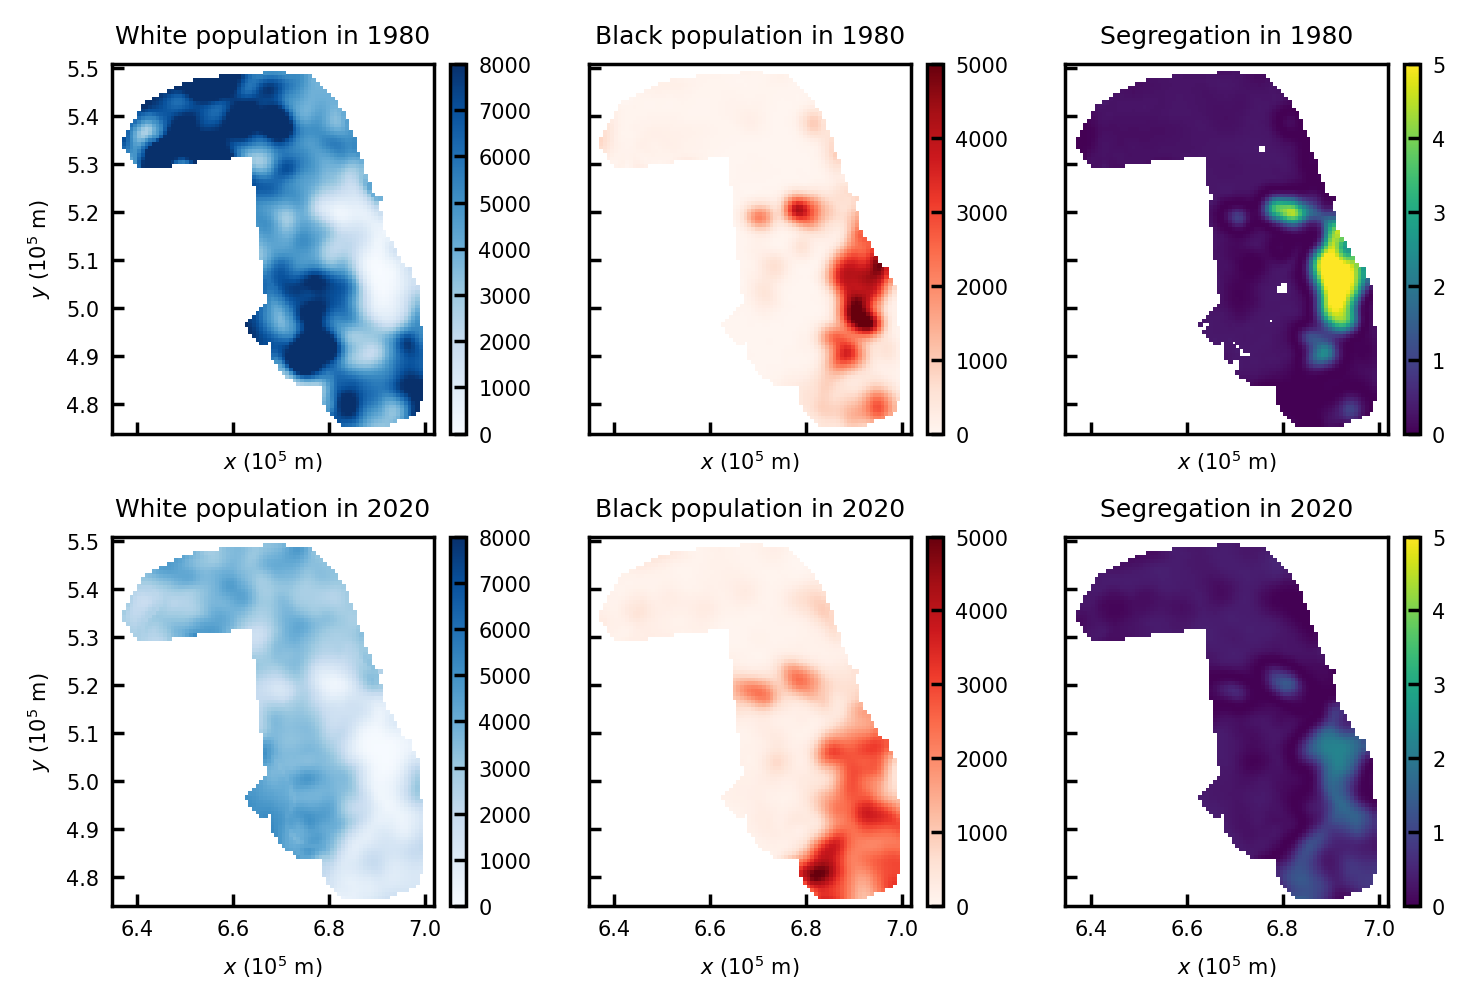

In [11]:
from pinn import *
modeltype = CubicDiffusionPINN
info = torch.load(f'data/{modeltype.__name__}', map_location='cpu')
model = QuadraticDiffusionPINN(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
model.iter = info['iteration']
plot(model)
model.print()

## Cubic Diffusion PINN

$$ \dot{\phi}_i = \nabla \cdot \big( D_{ij} \nabla \phi_j \big) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

$$ \dot{\phi}_i = D_{ij} \nabla^2 \phi_j + \nabla D_{ij} \cdot \nabla \phi_j $$

$$ \nabla D_{ij} =  c^1_{ij} \nabla \phi_A + c^2_{ij} \nabla \phi_B + 2 c^3_{ij} \phi_A \nabla \phi_A + 2 c^4_{ij} \phi_B \nabla \phi_B + c^5_{ij} (\phi_A \nabla \phi_B + \phi_b \nabla \phi_A) $$

[3, 256, 256, 256, 256, 256, 2]
(19005, 2)
[0.52927953 0.1454342 ] [0.24186814 0.19572213]
Iter = 500000	Loss = 3.879e-04, MSE = 3.795e-04, Phys = 8.468e-06
  dt P_w = div( D_wi grad(P_i))
	D_ww =  1.41e-06  + -3.09e-06 P_w + 2.05e-06 P_b + 2.3e-06 P_w^2 + -1.12e-06 P_b^2 + -3.56e-06 P_w P_b
	D_wb =  1.37e-06  + -8.23e-06 P_w + 3.09e-06 P_b + 7.98e-06 P_w^2 + -4.57e-06 P_b^2 + -2.98e-06 P_w P_b
  dt P_b = div( D_bi grad(P_i))
	D_bw =  -1.21e-06  + 3.98e-06 P_w + -1.15e-05 P_b + -3.61e-06 P_w^2 + 9.07e-06 P_b^2 + 1.71e-05 P_w P_b
	D_bb =  -5.91e-06  + 2.43e-05 P_w + 1.04e-05 P_b + -2.02e-05 P_w^2 + -4.15e-06 P_b^2 + -1.56e-05 P_w P_b



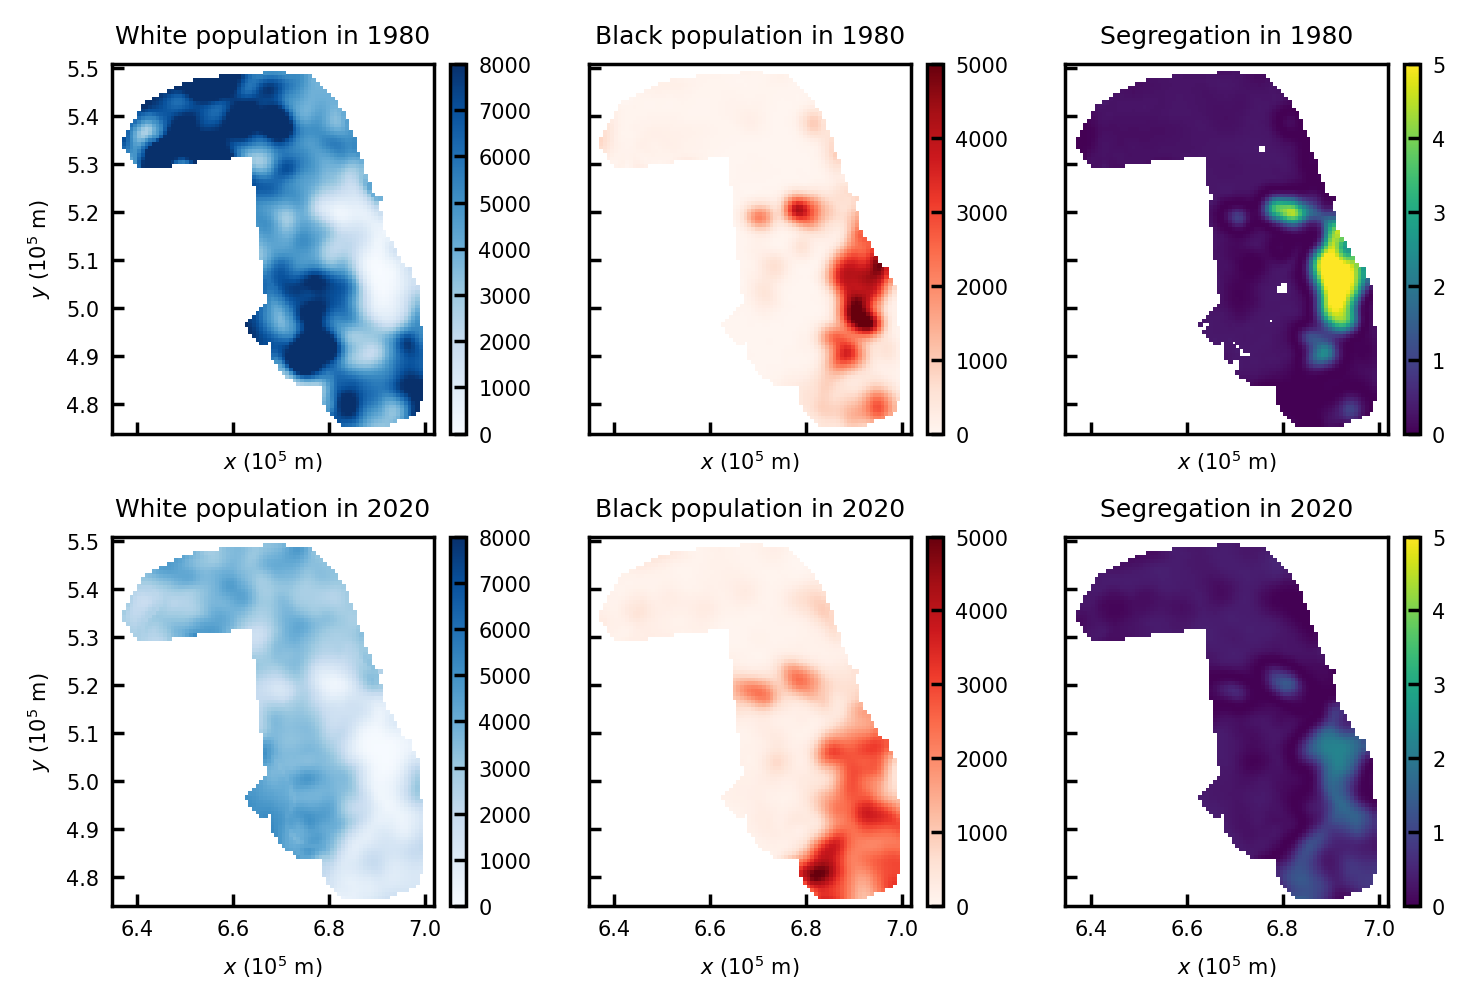

In [12]:
from pinn import *

modeltype = CubicDiffusionPINN
info = torch.load(f'data/{modeltype.__name__}', map_location='cpu')
model = modeltype(*margs, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
model.iter = info['iteration']
plot(model)
model.print()

## Simplified PINN

$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j - \Gamma_i \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B $$

# Verify on Burgers

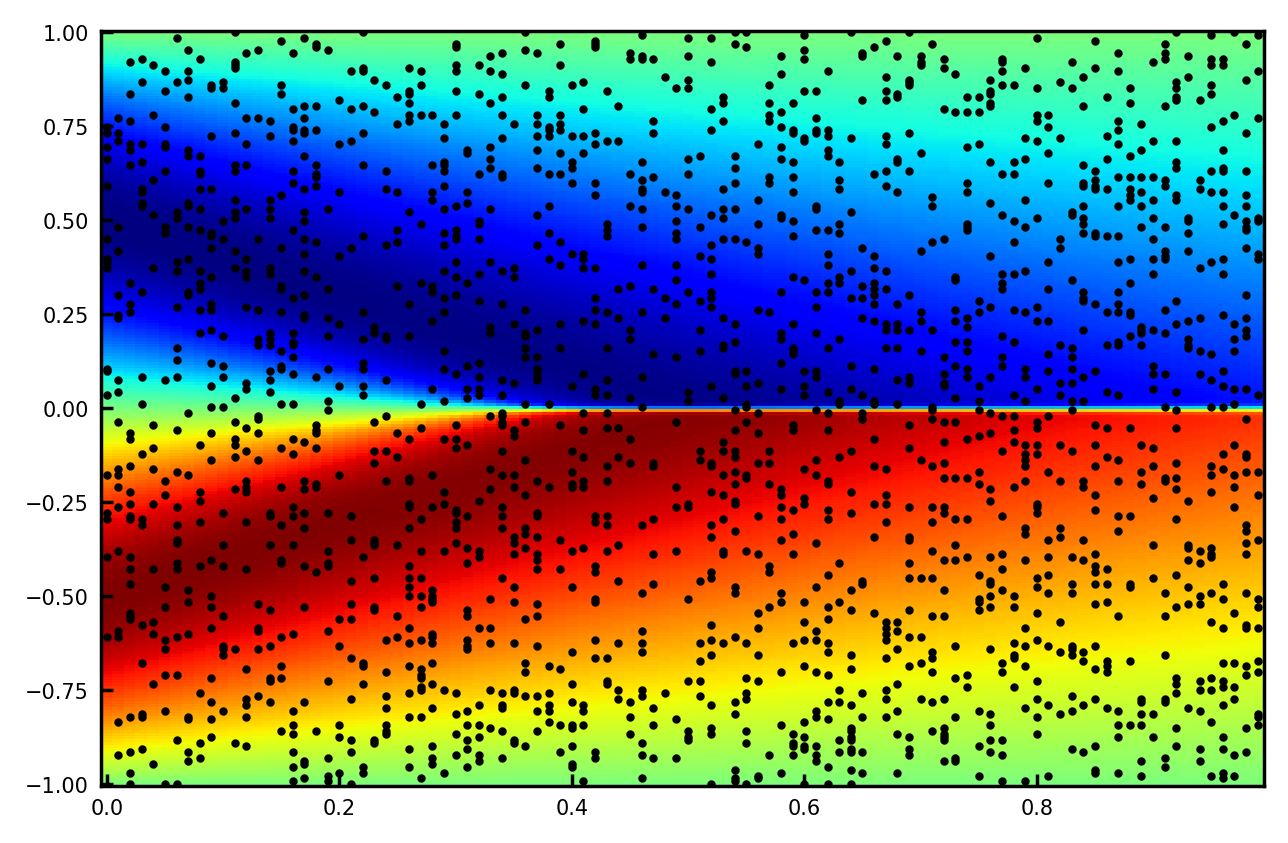

In [75]:
from scipy.io import loadmat
import numpy as np

data = loadmat('../gfnn/Burgers/data/burgers_shock.mat')

U_star = data['usol']
t_star = data['t']
X_star = data['x']

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

x = XX.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = U_star.flatten()[:,None] # NT x 1

fig, ax = plt.subplots(1, 1)
ax.pcolormesh(TT, XX, U_star, cmap='jet')

idx = np.random.choice(N*T, 2000, replace=False)
x_u = x[idx,:].squeeze()
t_u = t[idx,:].squeeze()
u_u = u[idx, :].squeeze()
ax.scatter(t_u, x_u, color='black', s=2)

In [78]:
from pinn import *

class BurgersPINN(PINN):
    def mse_loss(self, wb_u):
        mse = (wb_u[:, 0:1] - self.w_u).pow(2).mean()
        return mse
    
    def phys_loss(self, wb):
        t, y, x = self.t_u, self.y_u, self.x_u
        w = wb[:, 0:1]
        
        d_w = gradient(w, t, x)
        dt_w = d_w[..., 0:1]
        grad_w = d_w[..., 1:2]
        lapl_w = div(grad_w, x)
                
        lambda_1 = self.coefs[0, 0]
        eta = self.coefs[1, 0].exp()
        
        f_w = dt_w[..., 0] + lambda_1 * w * grad_w[..., 0] - eta * lapl_w
        phys = f_w.pow(2).mean()
        return phys
        
    def equation_string(self):
        coefs = self.coefs[:, 0].detach().cpu().numpy()
        eq =  f'dt P_w + {coefs[0]:.3f} w grad w = {np.exp(coefs[1]):.3f} grad^2 P_w'
        return eq

device = torch.device('cuda:0')
model = BurgersPINN(
    torch.from_numpy(x_u).float(),
    torch.from_numpy(np.ones_like(x_u)).float(),
    torch.from_numpy(t_u).float(),
    torch.from_numpy(u_u).float(),
    torch.from_numpy(np.ones_like(u_u)).float(),
    N_h=50,
    N_l=4,
    lbfgs_lr=1e1,
    print_every=1000,
)
model.to(device)

model.train()

[3, 50, 50, 50, 50, 2]
Starting L-BFGS optimization
Loss: 5.398835e-03, MSE: 4.076345e-03, Phys: 1.322490e-03, 
dt P_w + 0.847 w grad w = 0.009 grad^2 P_w

Loss: 1.472725e-03, MSE: 1.035403e-03, Phys: 4.373219e-04, 
dt P_w + 0.954 w grad w = 0.006 grad^2 P_w



KeyboardInterrupt: 

(256, 100) (256, 100)


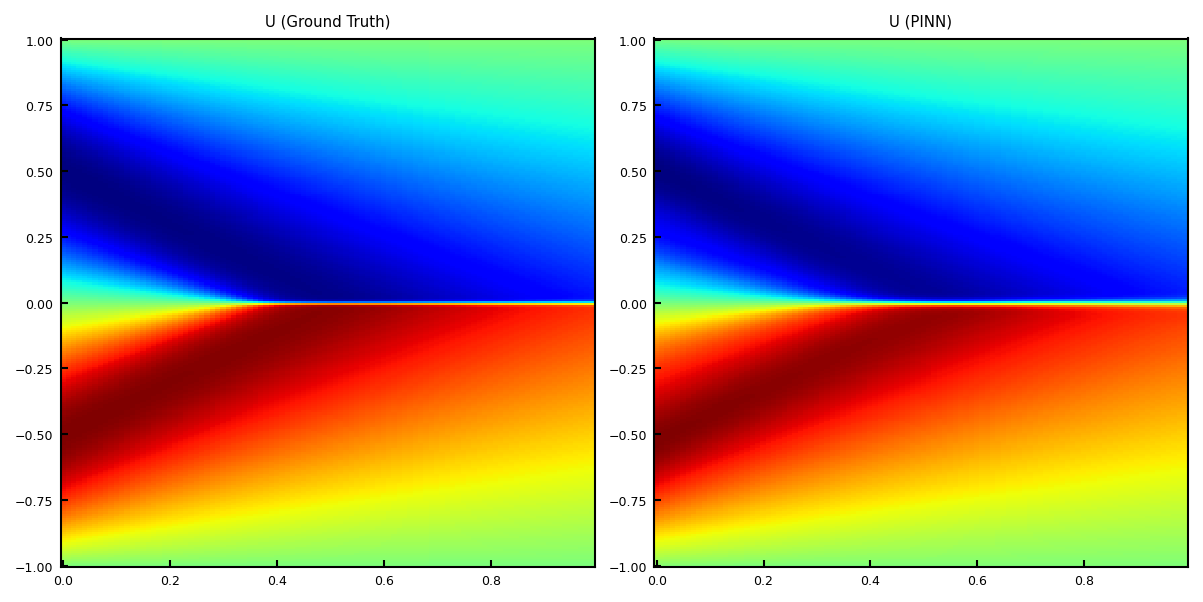

In [79]:
tyx = torch.from_numpy(np.stack([t, np.ones_like(x), x], axis=-1)).float().to(device).squeeze()
preds = model(tyx).detach().cpu().numpy()[:, 0]
u1 = preds.reshape(U_star.shape)
print(U_star.shape, u1.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
ax[0].pcolormesh(TT, XX, U_star, cmap='jet')
ax[1].pcolormesh(TT, XX, u1, cmap='jet')

ax[0].set_title('U (Ground Truth)')
ax[1].set_title('U (PINN)')
plt.tight_layout()